<p style="text-align:center;font-size:200%;"><b>Keyword Extracion
</b></p>
<p style="text-align:center;font-size:150%;"><b>Wikipedia Articles
</b></p>

To facilitate keyword extraction process for pulling related tweets from Twitter API, this notebook aims to download and analyse related Wikipedia articles and extract the related keywords using NLP techniques.

# Required packages

In [1]:
import wikipedia
import pandas as pd
from tqdm.notebook import trange,tqdm
import nltk
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
os.chdir('..')
from twitterED.utilities.utils import text_cleaning, get_top_n_words
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns 
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
# Libraries for text preprocessing
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Milan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Milan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Pulling data from wikipedia

In [2]:
# Adding the Wikipedia pages to pull data from
# You can simply add a Wikipedia article title to the following list
articles = ["COVID-19 pandemic in England","NHS Test and Trace","Coronavirus disease 2019"]
contents =[]
for artcl in tqdm(articles):
    p = wikipedia.page(artcl)
    content = p.content # Content of page
    #content = content.translate(removetable)
    contents.append(content)
    print(p.title)
    print(p.url)

COVID-19 pandemic in England
https://en.wikipedia.org/wiki/COVID-19_pandemic_in_England
NHS Test and Trace
https://en.wikipedia.org/wiki/NHS_Test_and_Trace
Coronavirus disease 2019
https://en.wikipedia.org/wiki/Coronavirus_disease_2019



# Data Pre-processing

In [3]:
# Creating the dataset from downloaded articles
dataset = pd.DataFrame (contents,columns=['txt'], index=articles)
dataset.index.name = 'Title'
dataset.head()

,txt
Title,
COVID-19 pandemic in England,The COVID-19 pandemic was first confirmed to h...
NHS Test and Trace,NHS Test and Trace is a government-funded serv...
Coronavirus disease 2019,Coronavirus disease 2019 (COVID-19) is a conta...


In [4]:
#Fetch wordcount for each article
dataset['word_count'] = dataset['txt'].apply(lambda x: len(str(x).split(" ")))
dataset[['txt','word_count']].head()

,txt,word_count
Title,,
COVID-19 pandemic in England,The COVID-19 pandemic was first confirmed to h...,6444
NHS Test and Trace,NHS Test and Trace is a government-funded serv...,4199
Coronavirus disease 2019,Coronavirus disease 2019 (COVID-19) is a conta...,9260


In [5]:
##Descriptive statistics of word counts
dataset.word_count.describe()

count       3.000000
mean     6634.333333
std      2535.862838
min      4199.000000
25%      5321.500000
50%      6444.000000
75%      7852.000000
max      9260.000000
Name: word_count, dtype: float64

In [6]:
#Identify common words (Stop words)
freq = pd.Series(' '.join(dataset['txt']).split()).value_counts()[:20]
freq

the         950
of          679
and         605
to          521
in          423
a           307
for         202
with        193
by          183
was         160
that        158
were        154
on          142
The         141
from        137
===         128
COVID-19    126
is          122
as          114
be          111
dtype: int64

In [7]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(dataset 
         ['txt']).split()).value_counts()[-20:]
freq1

workforce          1
"morally           1
95%                1
categories         1
Study              1
Channel            1
"Dido              1
discharges.        1
systems,           1
monocyte           1
NIOSH-certified    1
Applicable         1
sequence           1
crown              1
Rates              1
2.The              1
(23.1%             1
high,              1
similarity         1
CM,                1
dtype: int64

# Text Processing

Remove redundant text components and noise and, normilising data
* Normalistion: Handling multiple occurrences of the same word.
(learn, learned, learning, learner => learn)

    * Stemming: cleaning text by removing the suffixes
    * lemmatization: normalise the word based on the root of word



example:

In [8]:
lem = WordNetLemmatizer() 
stem = PorterStemmer()

In [10]:
word = "absolutely"
print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

stemming: absolut
lemmatization: absolutely


In [11]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords; added after analysing the text
new_words = ['may','march','april','also','people','uk','would','case','day',
             'country','government','said','percent','first']
stop_words = stop_words.union(new_words)
stop_words = stop_words.union(freq) 
stop_words = stop_words.union(freq1)
len(stop_words)

214

In [12]:
# cleaned and normalised text corpus

corpus = []
for i in trange(0, dataset.shape[0]):
    #Remove punctuations
    text = text_cleaning.rm_punctuation1(dataset['txt'][i])
    #Convert to lowercase
    text = text_cleaning.lower(text)
    #  remove words less than 4 charachters
    text = re.sub(r'\b\w{1,3}\b', '', text) 
    #remove tags
    text = text_cleaning.rm_tags(text)
    #remove digits
    text = text_cleaning.remove_digits(text)
    ##Convert to list from string
    text = text.split()
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

Visualising the text corpus after pre-processing to find most frequent words:

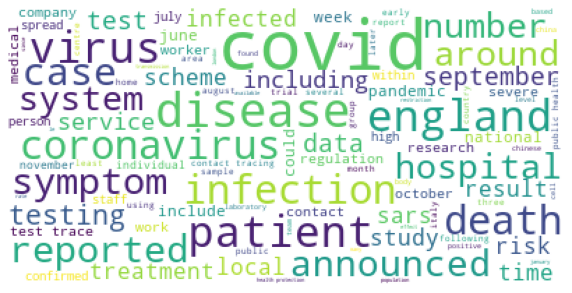

In [13]:
# Word cloud
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=str(stop_words),
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("./notebooks/figures/wordcld.png", dpi=900)

# Text preparation

To prepare text to become a machine learning understandable object, two measures should be taken:
* Tokenisation: converting the continuous text to a list of words
* Vectorisation so called feature extraction: converting the list of words to matrix of integers

Using the "bag of words model" which ignores the sequence of the words and just considers the frequencies.

In [14]:
# tokenising text and buliding the vocabulary of known words
cv=CountVectorizer(max_df=0.8,stop_words=stop_words,
                   max_features=10000, ngram_range=(1,3)) # variable of the CountVectorizer class
X=cv.fit_transform(corpus) # learn and build the vocabulary

In [15]:
list(cv.vocabulary_.keys())[:20]

['among',
 'chinese',
 'staying',
 'hotel',
 'york',
 'january',
 'responsible',
 'oversees',
 'budget',
 'planning',
 'delivery',
 'operation',
 'side',
 'mission',
 'nation',
 'address',
 'death',
 'unlike',
 'scotland',
 'wale']

In [16]:
from twitterED.utilities.utils import get_top_n_words

Visualising top 20 unigrams,bi-grams and tri-grams 

[Text(0, 0, 'covid'),
 Text(1, 0, 'health'),
 Text(2, 0, 'hospital'),
 Text(3, 0, 'death'),
 Text(4, 0, 'england'),
 Text(5, 0, 'test'),
 Text(6, 0, 'disease'),
 Text(7, 0, 'number'),
 Text(8, 0, 'case'),
 Text(9, 0, 'contact'),
 Text(10, 0, 'coronavirus'),
 Text(11, 0, 'patient'),
 Text(12, 0, 'virus'),
 Text(13, 0, 'infection'),
 Text(14, 0, 'public'),
 Text(15, 0, 'system'),
 Text(16, 0, 'symptom'),
 Text(17, 0, 'local'),
 Text(18, 0, 'reported'),
 Text(19, 0, 'announced')]

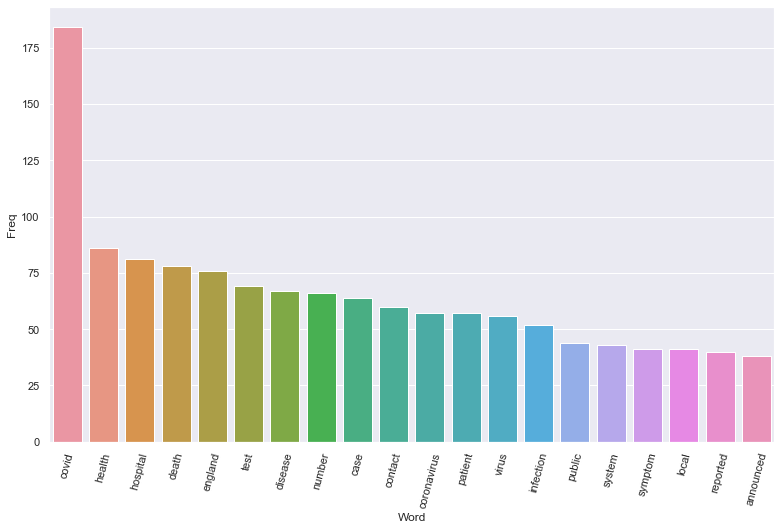

In [17]:
# top 20 most frequently occuring words
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df.to_csv('./data/processed/keywords/words.csv', index=False)
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

[Text(0, 0, 'test trace'),
 Text(1, 0, 'contact tracing'),
 Text(2, 0, 'public health'),
 Text(3, 0, 'health protection'),
 Text(4, 0, 'social distancing'),
 Text(5, 0, 'health england'),
 Text(6, 0, 'united state'),
 Text(7, 0, 'acute respiratory'),
 Text(8, 0, 'covid pandemic'),
 Text(9, 0, 'number death'),
 Text(10, 0, 'national institute'),
 Text(11, 0, 'total number'),
 Text(12, 0, 'institute health'),
 Text(13, 0, 'close contact'),
 Text(14, 0, 'world health'),
 Text(15, 0, 'health organization'),
 Text(16, 0, 'social care'),
 Text(17, 0, 'tested positive'),
 Text(18, 0, 'hospital death'),
 Text(19, 0, 'death hospital')]

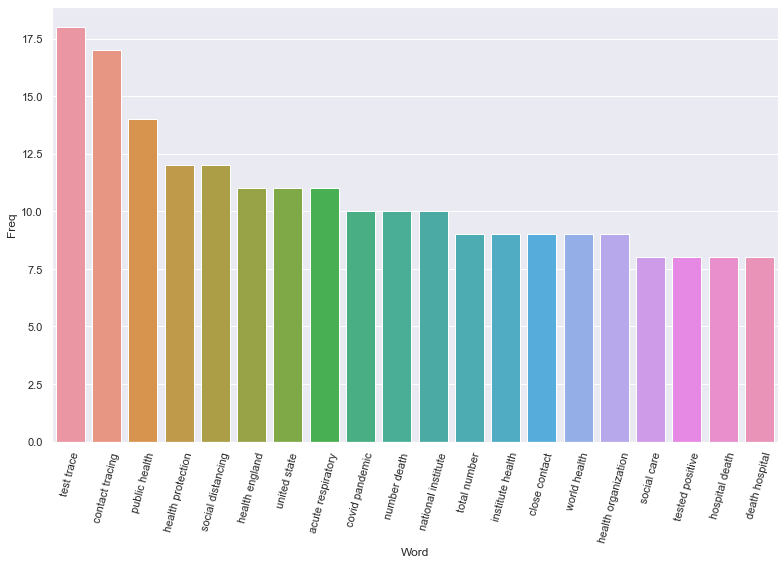

In [18]:
# most frequently occuring Bi-gramsMost frequently occuring Bi-grams
top_words = get_top_n_words(corpus, n=20,ngram_range=(2,2))
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df.to_csv('./data/processed/keywords/bi_grams.csv', index=False)
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

[Text(0, 0, 'public health england'),
 Text(1, 0, 'health protection coronavirus'),
 Text(2, 0, 'national institute health'),
 Text(3, 0, 'world health organization'),
 Text(4, 0, 'health social care'),
 Text(5, 0, 'department health social'),
 Text(6, 0, 'coronavirus disease covid'),
 Text(7, 0, 'severe acute respiratory'),
 Text(8, 0, 'acute respiratory syndrome'),
 Text(9, 0, 'food drug administration'),
 Text(10, 0, 'number death hospital'),
 Text(11, 0, 'personal protective equipment'),
 Text(12, 0, 'covid alert level'),
 Text(13, 0, 'national police chief'),
 Text(14, 0, 'police chief council'),
 Text(15, 0, 'contact tracing service'),
 Text(16, 0, 'respiratory syndrome coronavirus'),
 Text(17, 0, 'acute respiratory distress'),
 Text(18, 0, 'respiratory distress syndrome'),
 Text(19, 0, 'distress syndrome ards')]

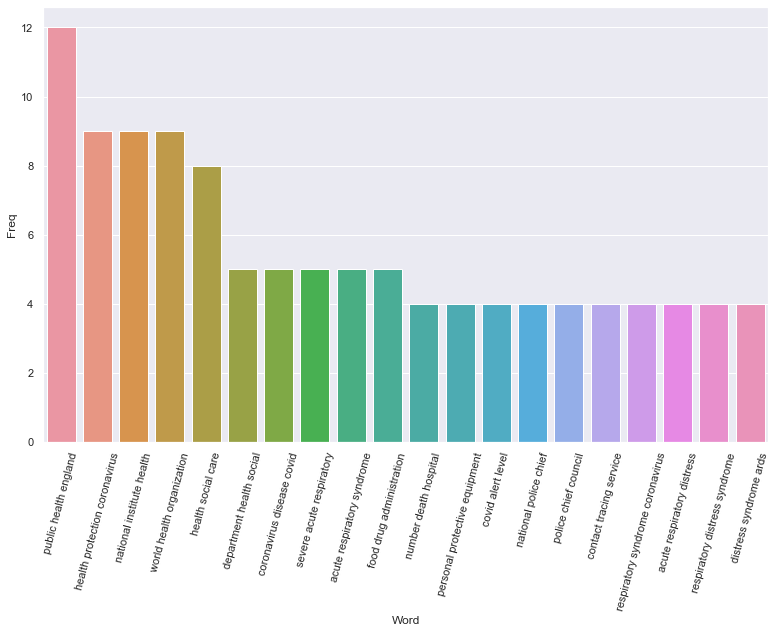

In [18]:
# most frequently occuring Bi-gramsMost frequently occuring Bi-grams
top_words = get_top_n_words(corpus, n=20,ngram_range=(3,3))
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df.to_csv('./data/processed/keywords/tri_grams.csv', index=False)
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=75)